#  Predicting the Past, United States Extension -- CURIE Recipes

## Introduction 
In this notebook, spent fuel recipes are picked from CURIE data. 

In [105]:
import numpy as np
import pandas as pd
from pandas.compat import StringIO
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pylab 
from scipy import stats
from pyne import nucname as nn 
import csv
import collections
import dateutil.parser as date
import jinja2
import os
import pathlib
import sys
import sqlite3 as lite
from matplotlib import cm
from IPython.display import Image

sys.path.append('../../../scripts/')
import analysis as an

region = 'united_states'

In [2]:
names = ['assembly_id','reactor_id', 'reactor_type', 'initial_uranium_kg','initial_enrichment','discharge_burnup','discharge_date','discharge_time','total_assembly_decay_heat_kw','name','evaluation_date','total_mass_g','total_radioactivity_curies']
df = pd.read_csv('SNF_nuclide_2020_07_01.dat',
                  sep='\s+',
                  index_col=False, 
                  names = names)

** Keep only burn up and discharge date ** 

In [17]:
date_isotope_burnup = df[['discharge_date','assembly_id','reactor_id','discharge_burnup']]
date_isotope_burnup = date_isotope_burnup.drop_duplicates(subset='assembly_id',keep = 'first')
date_burnup = date_isotope_burnup[['discharge_date','discharge_burnup']]
date_burnup = date_burnup.set_index('discharge_date')

date_burnup_average = date_burnup.groupby('discharge_date').mean()

** Plot of burn up of reactor assemblies vs. discharge year ** 

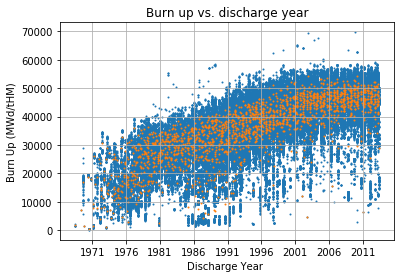

In [5]:
index = date_burnup.index.values
data = date_burnup.values
dts = pd.to_datetime(index)

index2 = date_burnup_average.index.values
data2 = date_burnup_average.values
dts2 = pd.to_datetime(index2)

plt.scatter(dts,data,s = 1)
plt.scatter(dts2,data2,s=1)

plt.grid()
plt.xlabel('Discharge Year ')
plt.ylabel('Burn Up (MWd/tHM)')
plt.title('Burn up vs. discharge year')
plt.savefig('figures/burnup.png', dpi=300)

** Burn up values in ascending order** 

In [48]:
np.set_printoptions(threshold=np.nan)
burnup_vals = np.around(data,decimals =0)
burnup_vals = np.sort(burnup_vals,axis = 0)
burnup_vals

array([[  177.],
       [  232.],
       [  310.],
       [  319.],
       [  324.],
       [  324.],
       [  325.],
       [  325.],
       [  326.],
       [  327.],
       [  330.],
       [  331.],
       [  334.],
       [  334.],
       [  335.],
       [  335.],
       [  337.],
       [  338.],
       [  343.],
       [  346.],
       [  350.],
       [  351.],
       [  352.],
       [  353.],
       [  353.],
       [  354.],
       [  354.],
       [  355.],
       [  360.],
       [  843.],
       [  858.],
       [  864.],
       [  865.],
       [  866.],
       [  960.],
       [  973.],
       [  979.],
       [  985.],
       [ 1000.],
       [ 1009.],
       [ 1024.],
       [ 1067.],
       [ 1075.],
       [ 1104.],
       [ 1105.],
       [ 1111.],
       [ 1119.],
       [ 1141.],
       [ 1154.],
       [ 1156.],
       [ 1164.],
       [ 1177.],
       [ 1180.],
       [ 1188.],
       [ 1191.],
       [ 1201.],
       [ 1220.],
       [ 1221.],
       [ 1222.

** Get a dataframe of names of isotopes and their mass fraction ** 

In [97]:
burnup15000 = df.loc[(df['discharge_burnup'] == 15000.0) & (df['assembly_id'] ==257342)]

def get_isotopic_massfrac(in_list):
    
    in_list = in_list[['name','total_mass_g']]
    total_mass = in_list['total_mass_g'].sum()
    in_list['total_mass_g'] = in_list['total_mass_g'] /total_mass
    in_list = in_list.set_index('name')
    in_list.rename(columns={'total_mass_g' :'massfrac'},inplace = True)
    
    return in_list 

burnup15000_massfrac = get_isotopic_massfrac(burnup15000)

/home/gwenchee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


** Change dataframe to dict ** 

In [101]:
def get_isotopic_composition_dict(in_list): 

    """ Returns a dictionary of isotope and composition (in mass fraction)
    from a sample spent fuel composition of CURIE data

    Parameters
    ---------
    in_list: pandas dataframe
        pandas dataframe containing element names and mass fractions

    Returns
    -------
    data_dict: dict
        dictionary with key=[isotope],
        and value=[composition]
    """
    
    nucname = in_list.index.values
    massfrac = in_list.values

    data_dict = {}
    for i in range(len(nucname)): 
        data_dict.update({nn.id(nucname[i]):float(massfrac[i])})
    
    return data_dict

spent_burnup15000 = get_isotopic_composition_dict(burnup15000_massfrac)

** Next few sections are taken from CYCLUS_analysis.ipynb ** 

In [106]:
def import_csv(in_csv, delimit):
    """ Imports contents of a csv text file to a list of
    lists.

    Parameters
    ---------
    in_csv: str
        path and name of input csv file
    delimit: str
        delimiter of the csv file

    Returns
    -------
    data_list: list
        list of lists containing the csv data
    """
    with open(in_csv, encoding='utf-8') as source:
        sourcereader = csv.reader(source, delimiter=delimit)
        data_list = []
        for row in sourcereader:
            data_list.append(row)
    return data_list


recipes = import_csv('../../../database/vision_recipes/uox.csv', ',')

In [107]:
def load_template(in_template):
    """ Returns a jinja2 template from file.

    Parameters
    ---------
    in_template: str
        path and name of jinja2 template

    Returns
    -------
    output_template: jinja template object
    """
    with open(in_template, 'r') as default:
        output_template = jinja2.Template(default.read())
    return output_template


recipe_template = load_template('../templates/recipes_template.xml')

In [108]:
def get_composition_fresh(in_list, burnup):
    """ Returns a dictionary of isotope and composition (in mass fraction)
    using vision_recipes for fresh UOX fuel.

    Parameters
    ---------
    in_list: list
        list containing vision_recipes
    burnup: int
        burnup

    Returns
    -------
    data_dict: dict
        dictionary with key=[isotope],
        and value=[composition]
    """
    data_dict = {}
    for i in range(len(in_list)):
        if i > 1:
            if burnup == 33:
                data_dict.update({nn.id(in_list[i][0]):
                                  float(in_list[i][1])})
            elif burnup == 51:
                data_dict.update({nn.id(in_list[i][0]):
                                  float(in_list[i][3])})
            else:
                data_dict.update({nn.id(in_list[i][0]):
                                  float(in_list[i][5])})
    return data_dict


def get_composition_spent(in_list, burnup):
    """ Returns a dictionary of isotope and composition (in mass fraction)
    using vision_recipes for spent nuclear fuel

    Parameters
    ---------
    in_list: list
        list containing vision_recipes data
    burnup: int
        burnup

    Returns
    -------
    data_dict: dict
        dictionary with key=[isotope],
        and value=[composition]
    """
    data_dict = {}
    for i in range(len(in_list)):
        if i > 1:
            if burnup == 33:
                data_dict.update({nn.id(in_list[i][0]):
                                  float(in_list[i][2])})
            elif burnup == 51:
                data_dict.update({nn.id(in_list[i][0]):
                                  float(in_list[i][4])})
            else:
                data_dict.update({nn.id(in_list[i][0]):
                                  float(in_list[i][6])})
    return data_dict

fresh = get_composition_fresh(recipes, 51)
spent = get_composition_spent(recipes, 51)

In [110]:
def write_recipes(fresh_dict, spent_dict, in_template, burnup, region):
    """ Renders jinja template using fresh and spent fuel composition.

    Parameters
    ---------
    fresh_dict: dict
        dictionary with key=[isotope], and
        value=[composition] for fresh UOX
    spent_dict: dict
        dictionary with key=[isotope], and
        value=[composition] for spent fuel
    in_template: jinja template object
        jinja template object to be rendered
    burnup: int
        amount of burnup

    Returns
    -------
    null
        generates recipe files for cyclus.
    """
    out_path = 'cyclus/input/' + region + '/recipes/'
    pathlib.Path(out_path).mkdir(parents=True, exist_ok=True)
    rendered = in_template.render(fresh=fresh_dict,
                                  spent=spent_dict)
    with open(out_path + '/uox_' + str(burnup) + '.xml', 'w') as output:
        output.write(rendered)


write_recipes(fresh, spent_burnup15000, recipe_template, 15000, region)

In [111]:
pris = import_csv('../../../database/reactors_pris_2016.csv', ',')

In [112]:
def select_region(in_list, region):
    """ Returns a list of reactors that will be deployed for
    CYCLUS by checking the capacity and commercial date

    Parameters
    ----------
    in_list: list
            imported csv file in list format
    region: str
            name of the region

    Returns
    -------
    reactor_list: list
            list of reactors from PRIS
    """
    ASIA = {'IRAN', 'JAPAN', 'KAZAKHSTAN',
            'BANGLADESH', 'CHINA', 'INDIA',
            'UNITED ARAB EMIRATES', 'VIETNAM',
            'PAKISTAN', 'PHILIPPINES', 'SOUTH KOREA'
            }
    UNITED_STATES = {'UNITED STATES'}
    SOUTH_AMERICA = {'ARGENTINA', 'BRAZIL'}
    NORTH_AMERICA = {'CANADA', 'MEXICO', 'UNITED STATES'}
    EUROPE = {'UKRAINE', 'UNITED KINGDOM',
              'POLAND', 'ROMANIA', 'RUSSIA',
              'BELARUS', 'BELGIUM', 'BULGARIA',
              'GERMANY', 'ITALY', 'NETHERLANDS',
              'SWEDEN', 'SWITZERLAND', 'TURKEY',
              'SLOVENIA', 'SOVIET UNION', 'SPAIN',
              'CZECHOSLOVAKIA', 'FINLAND', 'FRANCE'
              }
    AFRICA = {'EGYPT', 'MOROCCO', 'SOUTH AFRICA', 'TUNISIA'}
    ALL = (SOUTH_AMERICA | NORTH_AMERICA |
           EUROPE | ASIA | AFRICA | UNITED_STATES)
    regions = {'ASIA': ASIA,
               'AFRICA': AFRICA,
               'EUROPE': EUROPE,
               'SOUTH_AMERICA': SOUTH_AMERICA,
               'NORTH_AMERICA': NORTH_AMERICA,
               'UNITED_STATES': UNITED_STATES,
               'ALL': ALL}
    if region.upper() not in regions.keys():
        raise ValueError(region + 'is not a valid region')
    reactor_list = []
    for row in in_list:
        country = row[0]
        if country.upper() in regions[region.upper()]:
            capacity = row[3]
            start_date = row[10]
            if confirm_deployment(start_date, capacity):
                reactor_list.append(row)
    return reactor_list


def confirm_deployment(date_str, capacity):
    """ Confirms if reactor is to be deployed for CYCLUS by
    checking if the capacity > 400 and if the commercial date
    is a proper date format.

    Parameters
    ----------
    date_str: str
            the commercial date string from PRIS data file
    capacity: str
            capacity in MWe from RPIS data file

    Returns
    -------
    is_deployed: bool
            determines whether the reactor will be deployed
            in CYCLUS
    """
    is_deployed = False
    if len(date_str) > 4 and float(capacity) > 400:
        try:
            date.parse(date_str)
            is_deployed = True
        except:
            pass
    return is_deployed


reactor_list = select_region(pris, 'UNITED_STATES')

In [113]:
def write_reactors(in_list, out_path, reactor_template):
    """ Renders CYCAMORE::reactor specifications using jinja2.

    Parameters
    ----------
    in_list: list
        list containing PRIS data
    out_path: str
        output path for reactor files
    reactor_template: str
        path to reactor template

    Returns
    -------
    null
        writes xml files with CYCAMORE::reactor config
    """
    if out_path[-1] != '/':
        out_path += '/'
    pathlib.Path(out_path).mkdir(parents=True, exist_ok=True)
    reactor_template = load_template(reactor_template)
    for row in in_list:
        capacity = float(row[3])
        if capacity >= 400:
            name = row[1].replace(' ', '_')
            refuel_time = 1
            assem_per_batch = 0
            assem_no = 0
            assem_size = 0
            reactor_type = row[2]
            latitude = row[13] if row[13] != '' else 0
            longitude = row[14] if row[14] != '' else 0
            if reactor_type in ['BWR', 'ESBWR']:
                assem_no = 732
                assem_per_batch = int(assem_no / 3)
                assem_size = 138000 / assem_no
            elif reactor_type in ['GCR', 'HWGCR']:  # Need batch number
                assem_no = 324
                assem_per_batch = int(assem_no / 3)
                assem_size = 114000 / assem_no
            elif reactor_type == 'HTGR':  # Need batch number
                assem_no = 3944
                assem_per_batch = int(assem_no / 3)
                assem_size = 39000 / assem_no
            elif reactor_type == 'PHWR':
                assem_no = 390
                assem_per_batch = int(assem_no / 45)
                assem_size = 80000 / assem_no
            elif reactor_type == 'VVER':  # Need batch number
                assem_no = 312
                assem_per_batch = int(assem_no / 3)
                assem_size = 41500 / assem_no
            elif reactor_type == 'VVER-1200':  # Need batch number
                assem_no = 163
                assem_per_batch = int(assem_no / 3)
                assem_size = 80000 / assem_no
            else:
                assem_no = 241
                assem_per_batch = int(assem_no / 3)
                assem_size = 103000 / assem_no
            config = reactor_template.render(name=name,
                                             lifetime=get_lifetime(row),
                                             refuel_time = refuel_time, 
                                             assem_size=assem_size,
                                             n_assem_core=assem_no,
                                             n_assem_batch=assem_per_batch,
                                             power_cap=row[3],
                                             lon=longitude,
                                             lat=latitude)
            with open(out_path + name.replace(' ', '_') + '.xml',
                      'w') as output:
                output.write(config)


def get_lifetime(in_row):
    """ Calculates the lifetime of a reactor using first
    commercial date and shutdown date. Defaults to 720 months
    if shutdown date is not available.

    Parameters
    ----------
    in_row: list
        single row from PRIS data that contains reactor
        information

    Returns
    -------
    lifetime: int
        lifetime of reactor
    """
    comm_date = in_row[10]
    shutdown_date = in_row[11]
    if not shutdown_date.strip():
        return 720
    else:
        n_days_month = 365.0 / 12
        delta = (date.parse(shutdown_date) - date.parse(comm_date)).days
        return int(delta / n_days_month)


out_path = 'cyclus/input/' + region + '/reactors'
reactor_template = '../templates/reactors_template.xml'
write_reactors(reactor_list, out_path, reactor_template)

In [114]:
def deploy_reactors(in_csv, region, start_year, deployinst_template,
                    inclusions_template, reactors_path, deployment_path):
    """ Generates xml files that specify the reactors that will be included
    in a CYCLUS simulation.

    Parameters
    ---------
    in_csv: str
        path to pris reactor database
    region: str
        region name
    start_year: int
        starting year of simulation
    deployinst_template: str
        path to deployinst template
    inclusions_template: str
        path to inclusions template
    reactors_path: str
        path containing reactor files
    deployment_path: str
        output path for deployinst xml

    Returns
    -------
    buildtime_dict: dict
        dictionary with key=[name of reactor], and
        value=[set of country and buildtime]
    """
    lists = []
    if reactors_path[-1] != '/':
        reactors_path += '/'
    for files in os.listdir(reactors_path):
        lists.append(reactors_path + files)
    in_data = import_csv(in_csv, ',')
    reactor_list = select_region(in_data, region)
    buildtime = get_buildtime(reactor_list, start_year, lists)
    write_deployment(buildtime, deployment_path, deployinst_template,
                     inclusions_template)
    return buildtime


def get_buildtime(in_list, start_year, path_list):
    """ Calculates the buildtime required for reactor
    deployment in months.

    Parameters
    ----------
    in_list: list
        list of reactors
    start_year: int
        starting year of simulation
    path_list: list
        list of paths to reactor files

    Returns
    -------
    buildtime_dict: dict
        dictionary with key=[name of reactor], and
        value=[set of country and buildtime]
    """
    buildtime_dict = {}
    for row in in_list:
        comm_date = date.parse(row[10])
        start_date = [comm_date.year, comm_date.month, comm_date.day]
        delta = ((start_date[0] - int(start_year)) * 12 +
                 (start_date[1]) +
                 round(start_date[2] / (365.0 / 12)))
        for index, reactor in enumerate(path_list):
            name = row[1].replace(' ', '_')
            country = row[0]
            file_name = (reactor.replace(
                os.path.dirname(path_list[index]), '')).replace('/', '')
            if (name + '.xml' == file_name):
                buildtime_dict.update({name: (country, delta)})
    return buildtime_dict


def write_deployment(in_dict, out_path, deployinst_template,
                     inclusions_template):
    """ Renders jinja template using dictionary of reactor name and buildtime.
    Outputs an xml file that uses xinclude to include the reactor xml files
    located in cyclus_input/reactors.

    Parameters
    ---------
    in_dict: dictionary
        dictionary with key=[reactor name], and value=[buildtime]
    out_path: str
        output path for files
    deployinst_template: str
        path to deployinst template
    inclusions_template: str
        path to inclusions template

    Returns
    -------
    null
        generates input files that have deployment and xml inclusions
    """
    if out_path[-1] != '/':
        out_path += '/'
    pathlib.Path(out_path).mkdir(parents=True, exist_ok=True)
    deployinst_template = load_template(deployinst_template)
    inclusions_template = load_template(inclusions_template)
    country_list = {value[0] for value in in_dict.values()}
    for nation in country_list:
        temp_dict = {}
        for reactor in in_dict.keys():
            if in_dict[reactor][0].upper() == nation.upper():
                temp_dict.update({reactor: in_dict[reactor][1]})
        pathlib.Path(out_path + nation.replace(' ', '_') +
                     '/').mkdir(parents=True, exist_ok=True)
        deployinst = deployinst_template.render(reactors=temp_dict)
        with open(out_path + nation.replace(' ', '_') +
                  '/deployinst.xml', 'w') as output1:
            output1.write(deployinst)
    inclusions = inclusions_template.render(reactors=in_dict)
    with open(out_path + 'inclusions.xml', 'w') as output2:
        output2.write(inclusions)


pris_file = '../../../database/reactors_pris_2016.csv'
deployinst_tmpl = '../templates/' + region + '/deployinst_template.xml'
inclusions_tmpl = '../templates/inclusions_template.xml'
reactor_path = 'cyclus/input/' + region + '/reactors'
dployment_path = 'cyclus/input/' + region + '/buildtimes'

buildtime = deploy_reactors(pris_file, region, 1965, deployinst_tmpl,
                            inclusions_tmpl, reactor_path, dployment_path)
print(reactor_path)
for k in list(buildtime.keys())[:1]:
    print(k, ': ', buildtime[k])

cyclus/input/united_states/reactors
HADDAM_NECK :  ('United States', 37)


In [115]:
def render_cyclus(cyclus_template, region, in_dict, out_path):
    """ Renders final CYCLUS input file with xml base, and institutions
    for each country

    Parameters
    ----------
    cyclus_template: str
        path to CYCLUS input file template
    region: str
        region chosen for CYCLUS simulation
    in_dict: dictionary
        in_dict should be buildtime_dict from get_buildtime function
    out_path: str
        output path for CYCLUS input file
    output_name:

    Returns
    -------
    null
        writes CYCLUS input file in out_path
    """
    if out_path[-1] != '/':
        out_path += '/'
    cyclus_template = load_template(cyclus_template)
    country_list = {value[0].replace(' ', '_') for value in in_dict.values()}
    rendered = cyclus_template.render(countries=country_list,
                                      base_dir=os.path.abspath(out_path) + '/')
    with open(out_path + region + '.xml', 'w') as output:
        output.write(rendered)


cyclus_tmpl = ('../templates/' + region + '/' + region + '_template.xml')
render_cyclus(cyclus_tmpl, region, buildtime, 'cyclus/input/')

In [116]:
#!rm cyclus/united_states.sqlite
!cyclus -i ./cyclus/input/united_states.xml -o ./cyclus/united_states_refueltime1_burnup15000.sqlite --warn-limit 0

              :                                                               
          .CL:CC CC             _Q     _Q  _Q_Q    _Q    _Q              _Q   
        CC;CCCCCCCC:C;         /_\)   /_\)/_/\\)  /_\)  /_\)            /_\)  
        CCCCCCCCCCCCCl       __O|/O___O|/O_OO|/O__O|/O__O|/O____________O|/O__
     CCCCCCf     iCCCLCC     /////////////////////////////////////////////////
     iCCCt  ;;;;;.  CCCC                                                      
    CCCC  ;;;;;;;;;. CClL.                          c                         
   CCCC ,;;       ;;: CCCC  ;                   : CCCCi                       
    CCC ;;         ;;  CC   ;;:                CCC`   `C;                     
  lCCC ;;              CCCC  ;;;:             :CC .;;. C;   ;    :   ;  :;;   
  CCCC ;.              CCCC    ;;;,           CC ;    ; Ci  ;    :   ;  :  ;  
   iCC :;               CC       ;;;,        ;C ;       CC  ;    :   ; .      
  CCCi ;;               CCC        ;;;.      .C ;   